# DSA4262 Individual Assignment 2

Lim Zhi Chao, A0252895N

Link to GitHub repository: https://github.com/lzc88/DSA4262

## Import Dependencies

In [1]:
import shap
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import Dataset
from scipy.sparse import hstack

from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)
from transformers.utils import logging as hf_logging

## 1. Introduction

In online communities, stress appears through informal, fragmented, and context-dependent narratives.

This project aims to build a binary classification model that distinguishes between “Stressed” and “Non-stressed” Reddit posts across multiple communities.

Predictive accuracy alone is insufficient. The broader goal is to understand:
- How stress is expressed linguistically
- Where models succeed and where they fail
- Whether stress expression differs across communities
- What risks arise when deploying such systems in real-world contexts

Detecting stress in the wild is fundamentally different from detecting keywords. It requires modeling subjective experience, indirect language, and social context.

## 2. Exploratory Data Analysis

### 2.1 Overview

In [2]:
train_df = pd.read_csv("../datasets/dreaddit/dreaddit-train.csv")
test_df = pd.read_csv("../datasets/dreaddit/dreaddit-test.csv")

train_na = train_df.isna().sum().sort_values(ascending=False)
test_na = test_df.isna().sum().sort_values(ascending=False)

print("TRAIN shape:", train_df.shape)
print("TEST shape:", test_df.shape)

print("\nTRAIN missing values (top 3 cols):")
print(train_na.head(3))

print("\nTEST missing values (top 3 cols):")
print(test_na.head(3))

TRAIN shape: (2838, 116)
TEST shape: (715, 116)

TRAIN missing values (top 3 cols):
subreddit                0
lex_liwc_focuspresent    0
lex_liwc_informal        0
dtype: int64

TEST missing values (top 3 cols):
id                       0
lex_liwc_focuspresent    0
lex_liwc_informal        0
dtype: int64


In [3]:
cols = list(train_df.columns)
cols.sort(reverse=False)

for idx, col in enumerate(cols, start=1):
    unique_vals = train_df[col].unique()
    print(f"[{idx:03d}] {col}: {len(unique_vals)} unique values")

[001] confidence: 10 unique values
[002] id: 2838 unique values
[003] label: 2 unique values
[004] lex_dal_avg_activation: 2606 unique values
[005] lex_dal_avg_imagery: 2111 unique values
[006] lex_dal_avg_pleasantness: 2615 unique values
[007] lex_dal_max_activation: 54 unique values
[008] lex_dal_max_imagery: 6 unique values
[009] lex_dal_max_pleasantness: 41 unique values
[010] lex_dal_min_activation: 22 unique values
[011] lex_dal_min_imagery: 2 unique values
[012] lex_dal_min_pleasantness: 33 unique values
[013] lex_liwc_AllPunc: 990 unique values
[014] lex_liwc_Analytic: 1435 unique values
[015] lex_liwc_Apostro: 510 unique values
[016] lex_liwc_Authentic: 978 unique values
[017] lex_liwc_Clout: 1323 unique values
[018] lex_liwc_Colon: 132 unique values
[019] lex_liwc_Comma: 546 unique values
[020] lex_liwc_Dash: 221 unique values
[021] lex_liwc_Dic: 833 unique values
[022] lex_liwc_Exclam: 127 unique values
[023] lex_liwc_OtherP: 348 unique values
[024] lex_liwc_Parenth: 216 uni

In [4]:
# Observe non lexical features
sample_df = train_df.loc[:, ~train_df.columns.str.startswith("lex_")]
sample_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,1.00,1,7.910952,-0.204167


The training dataset contains 2,838 samples across 10 subreddits.

Each sample contains:
- Raw post text `text`
- Binary stress label `label`
- Annotator confidence score `confidence`
- 100+ engineered lexical (LIWC, DAL), syntactic, sentiment, and social media features

The dataset contains 2,343 unique `post_id` across 2,838 rows.

This indicates that multiple samples may originate from the same original post, very likely segmented by `sentence_range`.

If samples from the same post appear in both training and validation splits, there might be data leakage, resulting in inflated performance.

To prevent this, I use group-based splitting by `post_id` during cross-validation.

### 2.2 Class Distribution (`label`, `subreddit`)

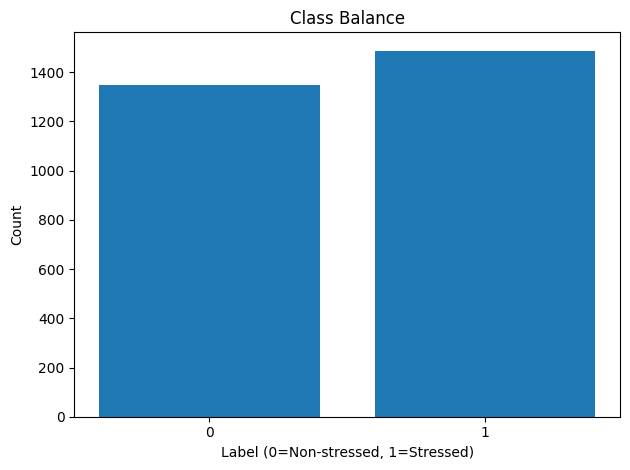

Label counts, proportions:
0 (Non-stressed) : 1350 (47.57%)
1 (Stressed)     : 1488 (52.43%)


In [5]:
label_counts = train_df["label"].value_counts().sort_index()
neg_count = label_counts.get(0, 0)
pos_count = label_counts.get(1, 0)

plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Class Balance")
plt.xlabel("Label (0=Non-stressed, 1=Stressed)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Label counts, proportions:")
print("0 (Non-stressed) :", neg_count, f"({neg_count/len(train_df) * 100:.2f}%)")
print("1 (Stressed)     :", pos_count, f"({pos_count/len(train_df) * 100:.2f}%)")

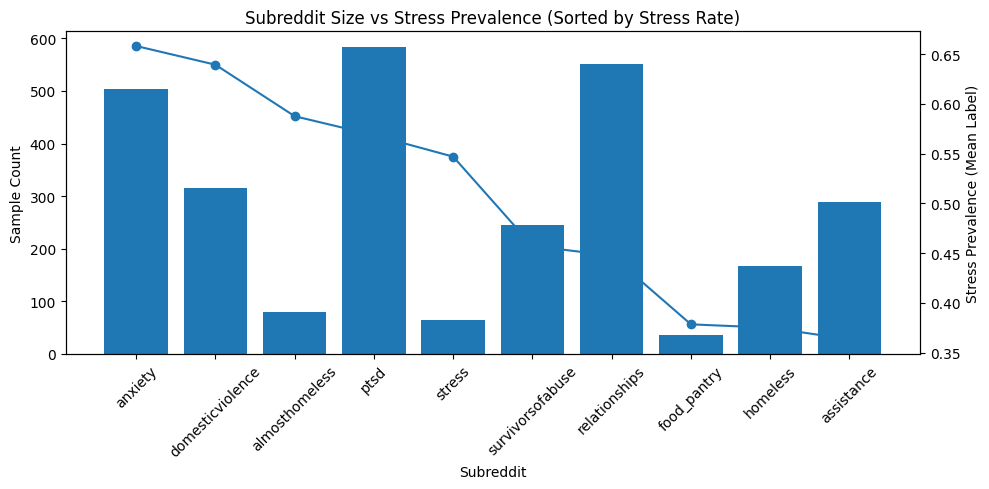

subreddit
anxiety             0.658052
domesticviolence    0.639241
almosthomeless      0.587500
ptsd                0.568493
stress              0.546875
survivorsofabuse    0.457143
relationships       0.447464
food_pantry         0.378378
homeless            0.375000
assistance          0.363322
Name: label, dtype: float64
subreddit
ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: count, dtype: int64


In [6]:
sub_counts = train_df["subreddit"].value_counts()
stress_rate = train_df.groupby("subreddit")["label"].mean().sort_values(ascending=False)
order = stress_rate.sort_values(ascending=False).index
sub_counts_sorted = sub_counts.loc[order]
stress_rate_sorted = stress_rate.loc[order]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(sub_counts_sorted.index, sub_counts_sorted.values)
ax1.set_xlabel("Subreddit")
ax1.set_ylabel("Sample Count")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(sub_counts_sorted.index, stress_rate_sorted.values, marker="o")
ax2.set_ylabel("Stress Prevalence (Mean Label)")

plt.title("Subreddit Size vs Stress Prevalence (Sorted by Stress Rate)")
plt.tight_layout()
plt.show()

print(stress_rate)
print(sub_counts)

Overall, the stress prevalence is approximately ~52%.

However, stress prevalence varies significantly across subreddits, ranging from ~66% to ~36%.

This variation suggests that:
- Community norms likely influence stress expression
- Subreddit membership itself may act as a predictive signal

We should also note that the subreddit sizes vary considerably (r/ptsd and r/relationships are much larger than r/food_pantry).

This imbalance may influence model learning:
- Larger subreddits may dominate feature learning
- Smaller subreddits may suffer from unstable performance

**Per-subreddit evaluation will therefore be reported.**

### 2.3 Confidence Distribution (`label`, `confidence`)

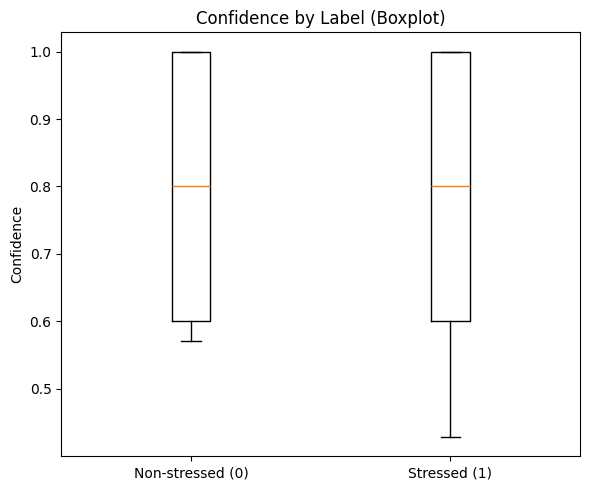

       count      mean       std  median       min  max
label                                                  
0       1350  0.804543  0.179652     0.8  0.571429  1.0
1       1488  0.812990  0.174597     0.8  0.428571  1.0


In [7]:
conf0 = train_df.loc[train_df["label"] == 0, "confidence"].values
conf1 = train_df.loc[train_df["label"] == 1, "confidence"].values

plt.figure(figsize=(6, 5))
plt.boxplot([conf0, conf1], tick_labels=["Non-stressed (0)", "Stressed (1)"])
plt.title("Confidence by Label (Boxplot)")
plt.ylabel("Confidence")
plt.tight_layout()
plt.show()

conf_stats = train_df.groupby("label")["confidence"].agg(
    ["count", "mean", "std", "median", "min", "max"]
)

print(conf_stats)

In [8]:
train_df_copy = train_df.copy()

bins = [0.0, 0.5, 0.7, 0.85, 1.01]
labels = ["<=0.50", "0.50-0.70", "0.70-0.85", ">=0.85"]

train_df_copy["conf_bucket"] = pd.cut(
    train_df_copy["confidence"], bins=bins, labels=labels, include_lowest=True
)

bucket_stats = train_df_copy.groupby("conf_bucket")["label"].agg(["count", "mean"])
print(bucket_stats)

             count      mean
conf_bucket                 
<=0.50          36  1.000000
0.50-0.70      936  0.471154
0.70-0.85      708  0.563559
>=0.85        1158  0.528497


The annotator confidence scores range from 0.43 to 1.0. Lower confidence likely reflects ambiguous or subtle stress expression.

Annotation confidence does not show a monotonic relationship with stress. This is expected as confidence reflects label clarity rather than intensity of stress.

High-confidence posts include both clearly stressed and clearly non-stressed cases. Low-confidence posts (0.50–0.70) are nearly balanced, suggesting genuine ambiguity in stress expression.

This provides an opportunity to analyse performance across confidence buckets and investigate whether the model primarily captures obvious stress.

### 2.4 Text Length Analysis (`label`, `text`)

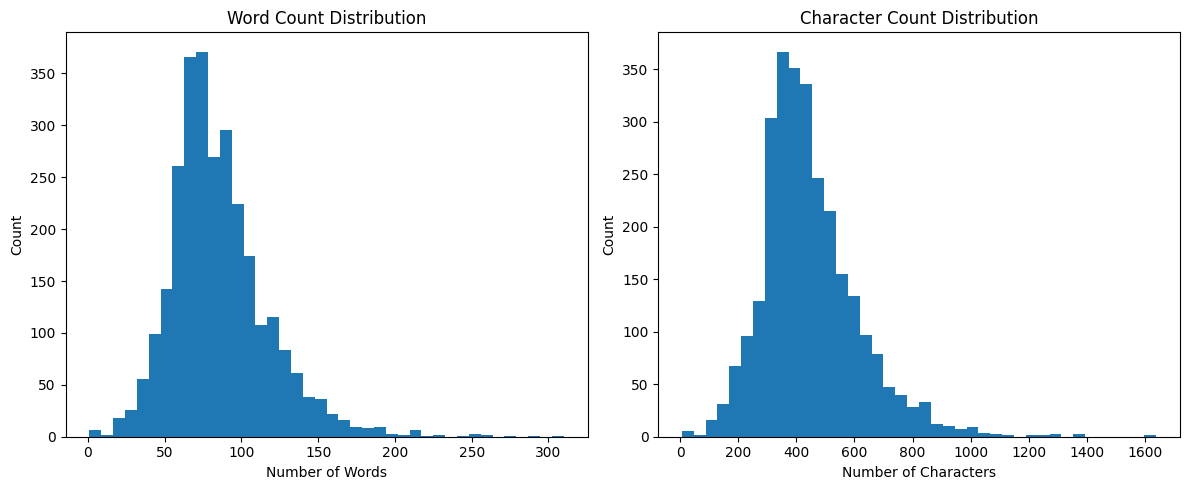


Text Length Summary:
       n_words  n_chars
count  2838.00  2838.00
mean     85.67   448.00
std      32.29   168.93
min       1.00     6.00
25%      65.00   339.00
50%      80.00   421.00
75%     101.00   528.75
max     310.00  1639.00


In [9]:
train_df_copy = train_df.copy()

# Handle non-string safely
text_series = train_df_copy["text"].fillna("").astype(str)

train_df_copy["n_words"] = text_series.str.split().str.len()
train_df_copy["n_chars"] = text_series.str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Word count
axes[0].hist(train_df_copy["n_words"].values, bins=40)
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Count")

# Character count
axes[1].hist(train_df_copy["n_chars"].values, bins=40)
axes[1].set_title("Character Count Distribution")
axes[1].set_xlabel("Number of Characters")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("\nText Length Summary:")
print(train_df_copy[["n_words", "n_chars"]].describe().round(2))

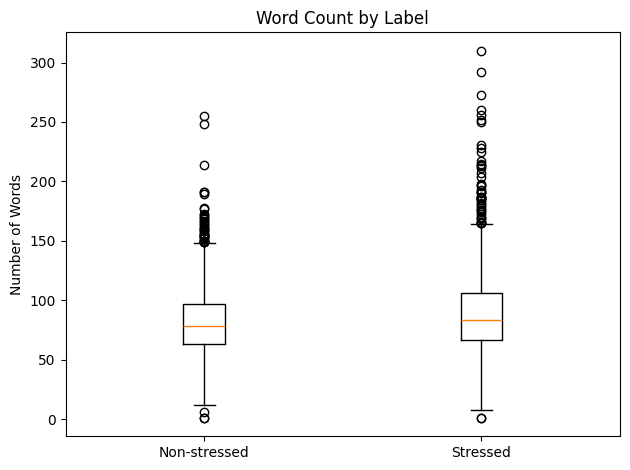

            mean        std  median
label                              
0      82.168148  29.135389    78.0
1      88.846774  34.614848    83.0


In [10]:
plt.figure()
plt.boxplot(
    [
        train_df_copy[train_df_copy["label"] == 0]["n_words"],
        train_df_copy[train_df_copy["label"] == 1]["n_words"],
    ],
    tick_labels=["Non-stressed", "Stressed"],
)
plt.title("Word Count by Label")
plt.ylabel("Number of Words")
plt.tight_layout()
plt.show()

length_stats = train_df_copy.groupby("label")["n_words"].agg(["mean", "std", "median"])
print(length_stats)

Stressed posts are slightly longer on average (~88.8 words) compared to non-stressed posts (~82.2 words), with a median difference of about 5 words.

While this suggests that stress expression might involve slightly more narrative elaboration, the difference is modest relative to the overall average length (~85 words).

Stressed posts exhibit higher variance, indicating greater heterogeneity in expression. It is likely that some posts are brief and intense, while others are extended personal narratives. This suggests that length alone is not a strong predictor of stress, and models should focus more on linguistic and emotional features rather than structural verbosity.

### 2.5 Feature Family Overview (`lex_*`, `syntax_*`, `social_*`, `sentiment`)

In [11]:
colnames = train_df.columns.tolist()
lex_cols = [c for c in colnames if c.startswith("lex_")]
syntax_cols = [c for c in colnames if c.startswith("syntax_")]
social_cols = [c for c in colnames if c.startswith("social_")]
sentiment_cols = [c for c in colnames if c == "sentiment" or c.startswith("sentiment_")]

print("Feature Family Sizes:")
print("lex_*     :", len(lex_cols))
print("syntax_*  :", len(syntax_cols))
print("social_*  :", len(social_cols))
print("sentiment :", len(sentiment_cols))

# Quick summary of key numeric features
key_numeric = []
for c in [
    "social_karma",
    "social_upvote_ratio",
    "social_num_comments",
    "syntax_ari",
    "syntax_fk_grade",
    "sentiment",
]:
    if c in train_df.columns:
        key_numeric.append(c)

if key_numeric:
    print("\nSummary of Key Numeric Features:")
    print(train_df[key_numeric].describe().round(3))

Feature Family Sizes:
lex_*     : 102
syntax_*  : 2
social_*  : 4
sentiment : 1

Summary of Key Numeric Features:
       social_karma  social_upvote_ratio  social_num_comments  syntax_ari  \
count      2838.000             2838.000             2838.000    2838.000   
mean         18.262                0.844                9.949       4.684   
std          79.419                0.175               21.798       3.316   
min           0.000                0.140                0.000      -6.620   
25%           2.000                0.750                2.000       2.464   
50%           5.000                0.890                5.000       4.322   
75%          10.000                1.000               10.000       6.506   
max        1435.000                1.000              416.000      24.074   

       syntax_fk_grade  sentiment  
count         2838.000   2838.000  
mean             5.449      0.041  
std              2.536      0.195  
min             -1.918     -1.000  
25%         

The dataset contains 102 lexical (LIWC-style) features, but only 2 syntax features and 4 social features. This indicates that the dataset is heavily oriented toward psycholinguistic analysis rather than structural or engagement-based signals.

Social features such as karma and number of comments are highly skewed, with most posts receiving low engagement and a small number receiving disproportionately high interaction. This suggests that social metadata may be noisy and weakly associated with stress.

Readability metrics (`syntax_ari` ~4.7, `syntax_fk_grade` ~5.4) indicate that posts are written at an accessible, conversational level. Stress in Reddit posts seem to be expressed via informal narratives, rather than complex linguistic structures.

Sentiment scores are approximately centered around neutral (mean ~0.04). This reinforces the idea that not all posts in stress-related communities are necessarily negative. Stress may be expressed subtly or pragmatically.

The engineered features span very different numerical ranges:
- `social_karma` up to 1435
- `social_upvote_ratio` between 0 and 1
- `syntax_ari` between -6 and 24

To prevent features with larger magnitudes from dominating the optimization process, all numeric features were standardised (zero mean, unit variance) before training logistic regression models.

Feature scaling was not required for transformer-based models, as they operate directly on tokenized text rather than numeric feature inputs.

## 3. Modeling Approach

The goal is to distinguish between stressed and non-stressed posts using a combination of:
- Engineered features (LIWC, syntax, social, sentiment)
- Text-derived signals

To prevent data leakage, group-based cross-validation is used with `post_id` as the grouping variable.

I evaluate three model configurations:
1. Engineered features only
2. Text feature only (TF-IDF)
3. Combined model

In [12]:
groups = train_df["post_id"]
gkf = GroupKFold(n_splits=5)

### 3.1 Feature Engineering

In [13]:
lex_cols = [c for c in train_df.columns if c.startswith("lex_")]
syntax_cols = [c for c in train_df.columns if c.startswith("syntax_")]
social_cols = [c for c in train_df.columns if c.startswith("social_")]
sentiment_cols = ["sentiment"]

feature_cols = lex_cols + syntax_cols + social_cols + sentiment_cols

numeric_transformer = Pipeline([("scaler", StandardScaler())])

preprocessor = ColumnTransformer([("num", numeric_transformer, feature_cols)])

model = Pipeline(
    [("preprocess", preprocessor), ("clf", LogisticRegression(max_iter=1000))]
)

X = train_df[feature_cols]
y = train_df["label"]

### 3.2 Engineered Features Only

In [14]:
f1_scores = []

for idx, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

    print(f"Fold {idx+1}: F1 Score = {f1:.4f}")

print("Engineered Features Average F1 Score:", sum(f1_scores) / len(f1_scores))

Fold 1: F1 Score = 0.7872
Fold 2: F1 Score = 0.7731
Fold 3: F1 Score = 0.7500
Fold 4: F1 Score = 0.7903
Fold 5: F1 Score = 0.7929
Engineered Features Average F1 Score: 0.778706277236755


### 3.3 Text Feature Only (TF-IDF)

In [15]:
X_text = train_df["text"]
y = train_df["label"]

f1_scores_text = []

for idx, (train_idx, val_idx) in enumerate(gkf.split(X_text, y, groups)):

    tfidf = TfidfVectorizer(
        max_features=10000, ngram_range=(1, 2), stop_words="english"
    )
    X_train = tfidf.fit_transform(X_text.iloc[train_idx])
    X_val = tfidf.transform(X_text.iloc[val_idx])

    y_train = y.iloc[train_idx]
    y_val = y.iloc[val_idx]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    f1 = f1_score(y_val, y_pred)
    f1_scores_text.append(f1)

    print(f"Fold {idx+1}: F1 Score = {f1:.4f}")

print("Text Feature Average F1 Score:", sum(f1_scores_text) / len(f1_scores_text))

Fold 1: F1 Score = 0.7798
Fold 2: F1 Score = 0.7524
Fold 3: F1 Score = 0.7293
Fold 4: F1 Score = 0.7586
Fold 5: F1 Score = 0.7712
Text Feature Average F1 Score: 0.7582799384636747


### 3.4 Combined Features

In [16]:
f1_scores_combined = []

for idx, (train_idx, val_idx) in enumerate(gkf.split(train_df, y, groups)):

    # Text
    tfidf = TfidfVectorizer(
        max_features=10000, ngram_range=(1, 2), stop_words="english"
    )
    X_train_text = tfidf.fit_transform(train_df["text"].iloc[train_idx])
    X_val_text = tfidf.transform(train_df["text"].iloc[val_idx])

    # Engineered
    scaler = StandardScaler()
    X_train_num = train_df.iloc[train_idx][feature_cols].values
    X_val_num = train_df.iloc[val_idx][feature_cols].values
    X_train_num = scaler.fit_transform(X_train_num)
    X_val_num = scaler.transform(X_val_num)

    # Combine
    X_train_comb = hstack([X_train_text, X_train_num])
    X_val_comb = hstack([X_val_text, X_val_num])

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_comb, y.iloc[train_idx])

    y_pred = clf.predict(X_val_comb)

    f1 = f1_score(y.iloc[val_idx], y_pred)
    f1_scores_combined.append(f1)

    print(f"Fold {idx+1}: F1 Score = {f1:.4f}")

print(
    "Combined Features Average F1 Score:",
    sum(f1_scores_combined) / len(f1_scores_combined),
)

Fold 1: F1 Score = 0.7864
Fold 2: F1 Score = 0.7815
Fold 3: F1 Score = 0.7521
Fold 4: F1 Score = 0.7885
Fold 5: F1 Score = 0.8090
Combined Features Average F1 Score: 0.7834800958541923


## 4. Results (Combined Features, TF-IDF, Logistic Regression)

### 4.1 Feature Engineering (Same as Training)

In [17]:
lex_cols = [c for c in train_df.columns if c.startswith("lex_")]
syntax_cols = [c for c in train_df.columns if c.startswith("syntax_")]
social_cols = [c for c in train_df.columns if c.startswith("social_")]
sentiment_cols = ["sentiment"]

feature_cols = lex_cols + syntax_cols + social_cols + sentiment_cols

y_train = train_df["label"]
y_test = test_df["label"]

### 4.2  Evaluation

In [18]:
# Text
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")
X_train_text = tfidf.fit_transform(train_df["text"])
X_test_text = tfidf.transform(test_df["text"])

# Engineered
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[feature_cols])
X_test_num = scaler.transform(test_df[feature_cols])

# Combine
X_train_comb = hstack([X_train_text, X_train_num])
X_test_comb = hstack([X_test_text, X_test_num])

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_comb, y_train)

# Test
y_pred_lr = clf.predict(X_test_comb)

# Evaluate
f1 = f1_score(y_test, y_pred_lr)

print("Evaluation results for combined features (TF-IDF):\n")
print("Test F1:", f1)
print("\nClassification report:\n", classification_report(y_test, y_pred_lr, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

Evaluation results for combined features (TF-IDF):

Test F1: 0.7694300518134715

Classification report:
               precision    recall  f1-score   support

           0     0.7692    0.6936    0.7295       346
           1     0.7370    0.8049    0.7694       369

    accuracy                         0.7510       715
   macro avg     0.7531    0.7493    0.7495       715
weighted avg     0.7526    0.7510    0.7501       715

Confusion matrix:
 [[240 106]
 [ 72 297]]


The combined model achieves a test F1-score of 0.769. This is close to the cross-validation estimate (0.783), indicating good generalization and minimal overfitting.

The small performance drop (~0.014) suggests that group-based cross-validation successfully prevented leakage and produced a reliable estimate of real-world performance.

## 5. Results (Text Feature Only, BERT)

### 5.1 Hyperparameter Tuning

In [19]:
# Suppress WARNING/INFO logs and HF progress bars
hf_logging.set_verbosity_error()
hf_logging.disable_progress_bar()

# Suppress pytorch pin_memoery warnings
warnings.filterwarnings(
    "ignore",
    message=".*pin_memory.*MPS.*",
)

SEED = 4262
np.random.seed(SEED)
torch.manual_seed(SEED)

gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
groups = train_df["post_id"].values
train_idx, val_idx = next(gss.split(train_df, train_df["label"], groups=groups))

train_split = train_df.iloc[train_idx].reset_index(drop=True)
val_split = train_df.iloc[val_idx].reset_index(drop=True)

assert (
    len(set(train_split["post_id"]) & set(val_split["post_id"])) == 0
), "Leakage: post_id overlap!"


def make_hf(df):
    tmp = df[["text", "label"]].copy()
    tmp["text"] = tmp["text"].fillna("").astype(str)
    return Dataset.from_pandas(tmp, preserve_index=False)


hf_train = make_hf(train_split)
hf_val = make_hf(val_split)
hf_test = make_hf(test_df)

model_name = "distilbert-base-uncased"
# model_name = "bert-base-uncased" # slower but better results than distilbert

tokenizer = AutoTokenizer.from_pretrained(model_name)

MAX_LEN = 128


def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )


def tok_and_format(hf_ds):
    ds = hf_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
    ds = ds.rename_column("label", "labels")
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds


hf_train_tok = tok_and_format(hf_train)
hf_val_tok = tok_and_format(hf_val)
hf_test_tok = tok_and_format(hf_test)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds)}


search_space = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "num_train_epochs": [1, 2],
    "weight_decay": [0.0, 0.01],
}

combos = []
for lr in search_space["learning_rate"]:
    for ep in search_space["num_train_epochs"]:
        for wd in search_space["weight_decay"]:
            combos.append((lr, ep, wd))

best = {"eval_f1": -1, "params": None, "trainer": None}

results = []

for i, (lr, ep, wd) in enumerate(tqdm(combos, desc="Hyperparam combos"), start=1):

    params = {"lr": lr, "epochs": ep, "weight_decay": wd}

    print(f"\nCombi {i}/{len(combos)} {params}:")

    np.random.seed(SEED)
    torch.manual_seed(SEED)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./bert_tune/lr{lr}_ep{ep}_wd{wd}",
        seed=SEED,
        num_train_epochs=ep,
        learning_rate=lr,
        weight_decay=wd,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        report_to="none",
        logging_strategy="no",
        disable_tqdm=True,
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_train_tok,
        eval_dataset=hf_val_tok,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_f1 = trainer.state.best_metric

    results.append({**params, "eval_f1": eval_f1})

    if eval_f1 > best["eval_f1"]:
        best["eval_f1"] = eval_f1
        best["params"] = {"lr": lr, "epochs": ep, "wd": wd}
        best["trainer"] = trainer

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

Hyperparam combos:   0%|          | 0/12 [00:00<?, ?it/s]


Combi 1/12 {'lr': 1e-05, 'epochs': 1, 'weight_decay': 0.0}:
{'eval_loss': '0.4334', 'eval_f1': '0.8421', 'eval_runtime': '1.278', 'eval_samples_per_second': '327.8', 'eval_steps_per_second': '41.47', 'epoch': '1'}
{'train_runtime': '28.77', 'train_samples_per_second': '84.07', 'train_steps_per_second': '10.53', 'train_loss': '0.5294', 'epoch': '1'}

Combi 2/12 {'lr': 1e-05, 'epochs': 1, 'weight_decay': 0.01}:
{'eval_loss': '0.4335', 'eval_f1': '0.8421', 'eval_runtime': '1.261', 'eval_samples_per_second': '332.3', 'eval_steps_per_second': '42.03', 'epoch': '1'}
{'train_runtime': '28.65', 'train_samples_per_second': '84.44', 'train_steps_per_second': '10.58', 'train_loss': '0.5295', 'epoch': '1'}

Combi 3/12 {'lr': 1e-05, 'epochs': 2, 'weight_decay': 0.0}:
{'eval_loss': '0.5223', 'eval_f1': '0.7941', 'eval_runtime': '1.252', 'eval_samples_per_second': '334.6', 'eval_steps_per_second': '42.32', 'epoch': '1'}
{'eval_loss': '0.4176', 'eval_f1': '0.8401', 'eval_runtime': '1.278', 'eval_samp

{'eval_loss': '0.4411', 'eval_f1': '0.8142', 'eval_runtime': '1.253', 'eval_samples_per_second': '334.4', 'eval_steps_per_second': '42.29', 'epoch': '1'}
{'train_runtime': '28.46', 'train_samples_per_second': '85', 'train_steps_per_second': '10.65', 'train_loss': '0.4856', 'epoch': '1'}

Combi 11/12 {'lr': 3e-05, 'epochs': 2, 'weight_decay': 0.0}:
{'eval_loss': '0.5539', 'eval_f1': '0.7875', 'eval_runtime': '1.248', 'eval_samples_per_second': '335.7', 'eval_steps_per_second': '42.47', 'epoch': '1'}
{'eval_loss': '0.5603', 'eval_f1': '0.8263', 'eval_runtime': '2.754', 'eval_samples_per_second': '152.1', 'eval_steps_per_second': '19.24', 'epoch': '2'}
{'train_runtime': '74.68', 'train_samples_per_second': '64.78', 'train_steps_per_second': '8.114', 'train_loss': '0.4025', 'epoch': '2'}

Combi 12/12 {'lr': 3e-05, 'epochs': 2, 'weight_decay': 0.01}:
{'eval_loss': '0.5552', 'eval_f1': '0.7875', 'eval_runtime': '3.473', 'eval_samples_per_second': '120.6', 'eval_steps_per_second': '15.26', 'e

In [20]:
results_df = (
    pd.DataFrame(results).sort_values("eval_f1", ascending=False).reset_index(drop=True)
)

print(results_df.to_string(index=False))

print("\nBest validation F1:", best["eval_f1"])
print("Best params:", best["params"])

     lr  epochs  weight_decay  eval_f1
0.00002       1          0.01 0.851695
0.00002       1          0.00 0.849257
0.00001       2          0.01 0.842553
0.00001       1          0.00 0.842105
0.00001       1          0.01 0.842105
0.00001       2          0.00 0.840085
0.00003       2          0.00 0.826271
0.00003       2          0.01 0.826271
0.00002       2          0.00 0.823779
0.00002       2          0.01 0.823779
0.00003       1          0.00 0.814196
0.00003       1          0.01 0.814196

Best validation F1: 0.8516949152542372
Best params: {'lr': 2e-05, 'epochs': 1, 'wd': 0.01}


### 5.2 Threshold Tuning

In [21]:
trainer = best["trainer"]

val_pred = trainer.predict(hf_val_tok)
val_logits = val_pred.predictions
y_val = val_pred.label_ids

val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()[:, 1]

thresholds = np.linspace(0.05, 0.95, 181)
best_t, best_f1 = 0.5, -1

for t in thresholds:
    yhat = (val_probs >= t).astype(int)
    f1 = f1_score(y_val, yhat)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold (val):", best_t)
print("Best F1 at threshold (val):", best_f1)

Best threshold (val): 0.4799999999999999
Best F1 at threshold (val): 0.8529411764705882


### 5.3 Evaluate

After selecting hyperparameters using the validation split (grouped by `post_id` to prevent leakage), I will retrain a fresh model on the **entire training set** (train+val combined). This maximizes the amount of supervised data available for the final model.

The decision threshold for F1 was tuned on the validation set and then fixed for the final evaluation on the held-out test set.

In [22]:
hf_logging.enable_progress_bar()

hf_full_train = make_hf(train_df)
hf_full_train_tok = tok_and_format(hf_full_train)

best_params = best["params"]

final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)

final_args = TrainingArguments(
    output_dir="./bert_final",
    seed=SEED,
    num_train_epochs=best_params["epochs"],
    learning_rate=best_params["lr"],
    weight_decay=best_params["wd"],
    per_device_eval_batch_size=16,
    eval_strategy="no",
    save_strategy="no",
    report_to="none",
    logging_strategy="no",
    disable_tqdm=True,
    dataloader_pin_memory=False,
)

final_trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=hf_full_train_tok,
)

final_trainer.train()

Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'train_runtime': '77.61', 'train_samples_per_second': '36.57', 'train_steps_per_second': '4.574', 'train_loss': '0.4839', 'epoch': '1'}


TrainOutput(global_step=355, training_loss=0.48387859505666814, metrics={'train_runtime': 77.6099, 'train_samples_per_second': 36.567, 'train_steps_per_second': 4.574, 'train_loss': 0.48387859505666814, 'epoch': 1.0})

In [23]:
test_pred = final_trainer.predict(hf_test_tok)
test_logits = test_pred.predictions
y_test = test_pred.label_ids

test_probs = torch.softmax(torch.tensor(test_logits), dim=1).numpy()[:, 1]
y_pred_final = (test_probs >= best_t).astype(int)

print("FINAL Test F1:", f1_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final, digits=4))
print(confusion_matrix(y_test, y_pred_final))

FINAL Test F1: 0.8086734693877551
              precision    recall  f1-score   support

           0     0.8267    0.7168    0.7678       346
           1     0.7639    0.8591    0.8087       369

    accuracy                         0.7902       715
   macro avg     0.7953    0.7879    0.7882       715
weighted avg     0.7943    0.7902    0.7889       715

[[248  98]
 [ 52 317]]


### 5.4 Combined Features with BERT (Future Work)

It is plausible that the engineered features can provide complementary signals to BERT.

A natural extension is to stack BERT outputs (predicted logits) with the engineered features using a lightweight meta-classifier (logistic regression).

However, the stacking must be done carefully. The meta-classifier should be trained on **out-of-fold (OOF)** BERT predictions to avoid leakage. This avoids using BERT probabilities that were computed on the same examples BERT was trained on.

OOF stacking requires additional compute (training BERT across folds) and is left as future work.

## 6. BERT vs TF-IDF+LR

TF-IDF models represent text as bag-of-words features, capturing word frequency patterns while largely ignoring word order and deeper semantic relationships. Although n-grams partially encode local context, they do not model long-range dependencies, compositional meaning, or discourse structure across sentences.

To evaluate whether richer contextual modelling improves stress detection, I fine-tuned transformer-based classifiers (`distilbert-base-uncased` and `bert-base-uncased`) directly on the raw post text.

Transformer models leverage self-attention mechanisms to model interactions between words across the entire sequence. Unlike TF-IDF or LIWC-style aggregate counts, they learn contextualised representations in which the meaning of each word depends on surrounding words. This enables them to:
- Capture nuanced emotional framing (e.g., distinguishing past recovery from present distress),
- Interpret sentence-level relationships and narrative progression,
- Detect subtle contextual cues that may not rely solely on explicit emotion words.

On the held-out test set, `bert-base-uncased` substantially improves over the best classical model in **F1-score, Recall (stress class), and Precision (stress class)**

The improvement from TF-IDF+engineered features to transformer models suggests that stress expression contains contextual and compositional signals that are not fully captured by surface-level lexical frequencies. While LIWC features effectively quantify stylistic and affective markers, transformers additionally model how these signals interact across clauses and sentences.

`bert-base-uncased` slightly outperforms `distilbert-base-uncased`, likely due to its larger capacity and deeper architecture, which enable richer contextual representations. Nevertheless, DistilBERT achieves competitive performance with fewer parameters, suggesting that much of the stress signal is learnable even in compressed transformer models.

The reduction in false negatives is particularly important in stress detection, as failing to identify genuinely distressed individuals may carry greater consequences than incorrectly flagging non-stressed posts. In screening-oriented applications, false positives can often be reviewed by human moderators, whereas false negatives represent missed opportunities for timely support.

However, despite improved performance, BERT still misclassifies a non-trivial number of cases. This reinforces the inherent ambiguity of stress expression in natural language and highlights the need for careful threshold tuning, human oversight, and ethical safeguards in any real-world deployment.

## 7. Analyses

### 7.1 Psycholinguistic Signature of Stress (Univariate Contrasts)

In [24]:
# Compute mean per label for lexical features
lex_means = train_df.groupby("label")[lex_cols].mean().T

# Difference (Stressed - Non-stressed)
# If diff > 0, feature is higher in stressed posts
# If diff < 0, feature is higher in non-stressed posts
lex_means["diff"] = lex_means[1] - lex_means[0]

# Top features in stressed posts
top_stress = lex_means.sort_values("diff", ascending=False).head(15)

# Top features in non-stressed posts
top_nonstress = lex_means.sort_values("diff").head(15)

print("Top lexical features higher in stressed posts:")
print(top_stress[["diff"]])

print("\nTop lexical features higher in non-stressed posts:")
print(top_nonstress[["diff"]])

Top lexical features higher in stressed posts:
label                       diff
lex_liwc_Authentic     18.121137
lex_liwc_WC             6.504128
lex_liwc_i              3.731040
lex_liwc_function       3.250429
lex_liwc_Dic            2.563784
lex_liwc_negemo         2.347070
lex_liwc_focuspresent   2.108180
lex_liwc_pronoun        2.075300
lex_liwc_ppron          1.797747
lex_liwc_verb           1.383025
lex_liwc_WPS            1.248733
lex_liwc_adverb         1.125185
lex_liwc_cogproc        1.041854
lex_liwc_Apostro        1.022402
lex_liwc_affect         0.987493

Top lexical features higher in non-stressed posts:
label                      diff
lex_liwc_Tone        -30.843313
lex_liwc_Clout       -25.535724
lex_liwc_Analytic    -13.146843
lex_liwc_social       -3.260626
lex_liwc_AllPunc      -2.148875
lex_liwc_OtherP       -1.580318
lex_liwc_posemo       -1.377107
lex_liwc_affiliation  -1.032248
lex_liwc_Sixltr       -0.952100
lex_liwc_you          -0.883369
lex_liwc_article     

The `diff` value represents the difference in mean feature value between stressed and non-stressed posts (mean_stressed − mean_nonstressed). A larger positive `diff` indicates that a feature is more characteristic of stressed language, while a larger negative `diff` indicates that it is more characteristic of non-stressed language.

The lexical analysis reveals clear psycholinguistic distinctions between the two groups.

Stressed posts exhibit substantially higher levels of:

- `lex_liwc_Authentic`, suggesting a more personal and self-revealing writing style
- `lex_liwc_WC`, indicating longer posts overall
- `lex_liwc_i`, reflecting increased first-person singular usage and self-focus
- `lex_liwc_function`, suggesting denser relational and narrative language
- `lex_liwc_negemo`, indicating greater use of negative emotion words
- `lex_liwc_focuspresent` and related pronoun features, consistent with immediate, self-referential concern

Taken together, these patterns suggest that stressed individuals engage in more self-disclosure, heightened emotional expression, and present-oriented rumination. The linguistic profile reflects inward focus and active cognitive-emotional processing of current pressures.

In contrast, non-stressed posts show higher values for:
- `lex_liwc_Tone`, reflecting more positive and emotionally stable language
- `lex_liwc_Clout`, indicating greater confidence or perceived control
- `lex_liwc_Analytic`, suggesting more structured and formal thinking patterns
- `lex_liwc_social` and `lex_liwc_posemo`, reflecting outward-facing and socially engaged language

These posts appear more emotionally regulated, structured, and socially oriented, aligning with lower perceived stress and greater cognitive control.

Overall, the univariate results are consistent with psychological theories of stress, which describe stress as involving heightened emotional processing, increased self-focus, and diminished perceived control.

Importantly, however, mean differences reflect univariate separation only. A feature that differs strongly between groups does not necessarily exert a strong independent effect once other correlated variables are considered. In a multivariate model, predictive usefulness depends not only on mean differences, but also on variance, redundancy, and interactions within the broader feature set.

Thus, the `diff` analysis provides an initial indication of discriminative potential, while final feature importance must be evaluated within the fitted model.

### 7.2 What the Model Actually Uses (SHAP Analysis)

To assess which features the model actually relies on after accounting for correlation structure, I next examine SHAP values from the fitted logistic regression model.

/var/folders/_8/fcsdg0j925gb70yh11zzgvb40000gn/T/ipykernel_68309/1863606266.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


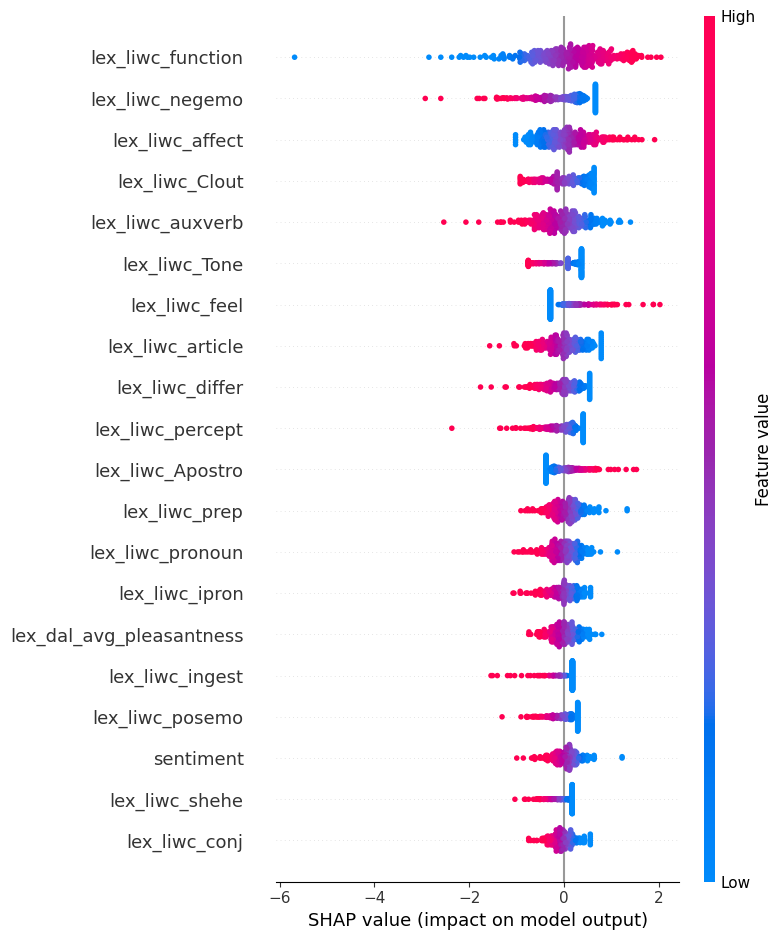

('lex_liwc_function', np.float64(0.7057295581544222))
('lex_liwc_negemo', np.float64(0.47805286118987417))
('lex_liwc_affect', np.float64(0.4286491232636479))
('lex_liwc_Clout', np.float64(0.4239182705147417))
('lex_liwc_auxverb', np.float64(0.41631361202658085))
('lex_liwc_Tone', np.float64(0.3666148149179256))
('lex_liwc_feel', np.float64(0.337624410663492))
('lex_liwc_article', np.float64(0.33359065862700665))
('lex_liwc_differ', np.float64(0.2946728844361727))
('lex_liwc_percept', np.float64(0.28708927773300036))
('lex_liwc_Apostro', np.float64(0.27545340445944705))
('lex_liwc_prep', np.float64(0.25583916084256886))
('lex_liwc_pronoun', np.float64(0.254428982635912))
('lex_liwc_ipron', np.float64(0.23143152531021988))
('lex_dal_avg_pleasantness', np.float64(0.22275278399111456))
('lex_liwc_ingest', np.float64(0.21084010333525596))
('lex_liwc_posemo', np.float64(0.20916337046721567))
('sentiment', np.float64(0.20761377064315142))
('lex_liwc_shehe', np.float64(0.19684327314073108))
(

In [25]:
X_train_comb = X_train_comb.tocsr()
X_test_comb = X_test_comb.tocsr()

explainer = shap.LinearExplainer(clf, X_train_comb)

X_sample = X_test_comb[:300].toarray()
shap_values = explainer.shap_values(X_sample)

text_feature_names = tfidf.get_feature_names_out()
num_feature_names = feature_cols

all_feature_names = list(text_feature_names) + list(num_feature_names)

shap.summary_plot(
    shap_values, X_sample, feature_names=all_feature_names, max_display=20
)

mean_abs_shap = np.abs(shap_values).mean(axis=0)

mean_shap = shap_values.mean(axis=0)  # signed direction
top_pos = np.argsort(mean_shap)[-10:][::-1]  # pushes toward stressed
top_neg = np.argsort(mean_shap)[:10]  # pushes toward non-stressed

feature_importance = sorted(
    zip(all_feature_names, mean_abs_shap), key=lambda x: x[1], reverse=True
)

top10 = feature_importance[:20]
for i in top10:
    print(i)

SHAP analysis indicates that the logistic regression model relies primarily on psycholinguistic markers rather than isolated keywords. Features such as overall affect, function words, auxiliary verbs, and first-person language exert strong influence on predicted stress probability, suggesting that the model captures broader emotional and stylistic patterns.

Interestingly, although negative emotion words (`lex_liwc_negemo`) are substantially higher on average in stressed posts, their marginal contribution in the multivariate model is negative. That is, conditional on other correlated features, higher values of `lex_liwc_negemo` slightly reduce predicted stress probability.

This counterintuitive effect reflects the distinction between univariate association and multivariate contribution. Emotional features such as overall affect, tone, and dominance (Clout) are correlated, causing much of the emotional signal to be absorbed by these broader variables. Once they are accounted for, isolated increases in negative emotion words may occur in reflective or recovery narratives rather than in posts expressing current distress.

This finding highlights that stress detection models do not equate stress with negativity alone. Instead, predictions are driven by a constellation of signals, including reduced dominance (low Clout), lower positive tone, increased narrative elaboration, and heightened emotional engagement. Stress expression appears to involve not merely negative sentiment, but intensified emotional processing combined with diminished perceived control and greater self-referential focus.

Importantly, the highest-ranked features by mean absolute SHAP value are LIWC-based psycholinguistic variables rather than individual lexical n-grams. This suggests that aggregate emotional and stylistic indicators contribute more strongly at a global level than any single word token, reinforcing the value of psychologically structured features for interpretable stress detection.

### 7.3 When Stress is Misclassified

In [26]:
probs = torch.softmax(torch.tensor(test_logits), dim=1).numpy()[:, 1]

error_df = test_df.copy()
error_df["pred"] = y_pred_final
error_df["prob_stress"] = probs

fp = error_df[(error_df["label"] == 0) & (error_df["pred"] == 1)]
fp_sorted = fp.sort_values("prob_stress", ascending=False)

fn = error_df[(error_df["label"] == 1) & (error_df["pred"] == 0)]
fn_sorted = fn.sort_values("prob_stress")

print("False Positives (top 5):")

for i in range(min(5, len(fp_sorted))):

    print(f"\nFalse Positive #{i+1}")
    row = fp_sorted.iloc[i]
    print("Probability of stress:", row["prob_stress"])
    print("Text:", row["text"])

print("\nFalse Negatives (top 5):")

for i in range(min(5, len(fn_sorted))):

    print(f"\nFalse Negative #{i+1}")
    row = fn_sorted.iloc[i]
    print("Probability of stress:", row["prob_stress"])
    print(row["text"])

False Positives (top 5):

False Positive #1
Probability of stress: 0.9450412
Text: I feel like I am just being written off because of my diagnosis before anyone even tries to look into it and see if anything else might be at play. I'd just as soon not say anything about my PTSD to be taken seriously, but it appears in my medical records. Or when I list my medications as required, Drs usually ask me what the meds are treating and it comes up then. Has anyone else had this experience? What has worked for you to be taken seriously?

False Positive #2
Probability of stress: 0.93910897
Text: None of the issues we discuss get addressed. 6) After a while, I get really pissed, my significant other gets angry with me over some issue, and she ends up breaking up with me. I am weary of this whole emotional drama that I have to go through to end a relationship. I almost feel like it's not even my choice to end a relationship. Is there a way to avoid this whole process?

False Positive #3
Probabili

**False Positives: Emotional Intensity vs Actual Stress**

High-confidence false positives often contain emotionally intense language or references to trauma. However, many of these posts describe past distress that has been resolved, recovery narratives, or emotionally reflective experiences rather than current stress.

This suggests that the model is highly sensitive to emotional intensity but does not fully distinguish between:
- Current vs retrospective stress
- Emotional tone vs actual psychological burden
- Objective hardship vs subjective distress

**False Negatives: Subtle and Pragmatic Stress**

In contrast, high-confidence false negatives frequently involve stress expressed in calm, structured, or pragmatic language. Posts describing financial hardship, relationship strain, or life transitions may lack explicit negative emotion words and instead adopt a problem-solving tone. These understated forms of stress are more difficult for the model to detect.

**Together, these patterns indicate that stress detection models primarily identify linguistically expressed emotional intensity rather than objective hardship. Subtle, context-dependent, or pragmatically framed stress remains challenging even for transformer-based models.**

### 7.4 Where Contextual Models Help (BERT vs TF-IDF, by subreddit)

In [27]:
comp = test_df[["subreddit", "label"]].copy()
comp["pred_lr"] = y_pred_lr
comp["pred_bert"] = y_pred_final

rows = []

for sub in comp["subreddit"].unique():
    s = comp[comp["subreddit"] == sub]

    n = len(s)
    n_stress = int((s["label"] == 1).sum())
    n_nonstress = int((s["label"] == 0).sum())
    stress_rate = float(s["label"].mean())

    f1_lr = float(f1_score(s["label"], s["pred_lr"]))
    f1_bert = float(f1_score(s["label"], s["pred_bert"]))

    rows.append(
        {
            "subreddit": sub,
            "n_samples": n,
            "n_stressed": n_stress,
            "n_nonstressed": n_nonstress,
            "stress_rate": stress_rate,
            "f1_lr": f1_lr,
            "f1_bert": f1_bert,
            "delta_f1": f1_bert - f1_lr,
        }
    )

delta_df = (
    pd.DataFrame(rows).sort_values("delta_f1", ascending=False).reset_index(drop=True)
)

print(delta_df)

          subreddit  n_samples  n_stressed  n_nonstressed  stress_rate  \
0     relationships        142          60             82     0.422535   
1           anxiety        147          85             62     0.578231   
2        assistance         66          21             45     0.318182   
3              ptsd        127          82             45     0.645669   
4  survivorsofabuse         70          31             39     0.442857   
5    almosthomeless         19          12              7     0.631579   
6            stress         14          10              4     0.714286   
7  domesticviolence         72          47             25     0.652778   
8          homeless         52          18             34     0.346154   
9       food_pantry          6           3              3     0.500000   

      f1_lr   f1_bert  delta_f1  
0  0.621849  0.692308  0.070459  
1  0.825397  0.891304  0.065908  
2  0.790698  0.842105  0.051408  
3  0.814371  0.857143  0.042772  
4  0.714286  0.

Model performance varies substantially across subreddits, suggesting that “stress” is expressed differently across Reddit communities. Overall, BERT improves over the classical logistic regression baseline in most subreddits.

Higher-performing communities such as r/anxiety, r/ptsd, and r/domesticviolence tend to contain more explicit emotional disclosure and stress-related narratives. In these settings, BERT’s contextual modelling likely helps by capturing compositional meaning and discourse cues beyond what TF–IDF and aggregate psycholinguistic features can represent.

In contrast, r/relationships remains substantially harder to classify despite a relatively large sample size. Posts in this subreddit often mix advice-seeking, conflict descriptions, and general relationship discussion, where emotional intensity does not always correspond to stress labels, increasing ambiguity.

r/homeless is also harder to clarify. This suggests that some posts describe severe hardship in a neutral, practical tone, which provides fewer overt linguistic markers of stress. This supports the broader insight that models tend to detect linguistically expressed distress rather than objective life hardship, especially when hardship is framed pragmatically rather than emotionally.

Finally, several subreddits have very small test sample sizes (r/stress, r/food_pantry), so their F1 scores should be interpreted cautiously due to high variance.

### 7.5 Model Performance vs Annotator Confidence

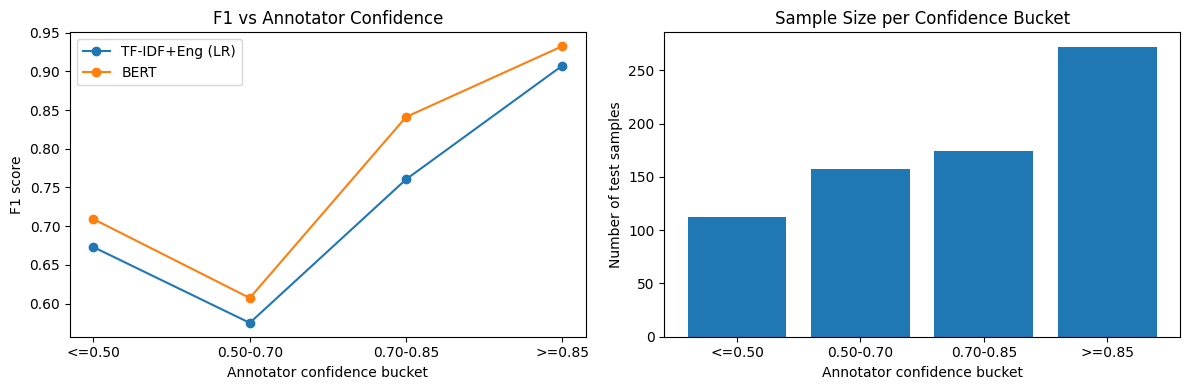

  conf_bucket    n  stress_rate     f1_lr   f1_bert
0      <=0.50  112     0.419643  0.672897  0.709091
1   0.50-0.70  157     0.496815  0.575000  0.607143
2   0.70-0.85  174     0.534483  0.760417  0.841026
3      >=0.85  272     0.555147  0.907348  0.932476


In [28]:
# Build confidence buckets
bins = [0.0, 0.5, 0.7, 0.85, 1.01]
labels = ["<=0.50", "0.50-0.70", "0.70-0.85", ">=0.85"]

conf_df = test_df[["label", "confidence", "subreddit", "text"]].copy()
conf_df["conf_bucket"] = pd.cut(
    conf_df["confidence"], bins=bins, labels=labels, include_lowest=True
)

# Attach predictions
conf_df["pred_lr"] = y_pred_lr
conf_df["pred_bert"] = y_pred_final
conf_df["prob_bert"] = test_probs  # optional but nice for later

# Compute metrics per bucket
rows = []
for b in labels:

    s = conf_df[conf_df["conf_bucket"] == b]
    if len(s) == 0:
        continue

    y_true = s["label"].values

    # LR
    yhat_lr = s["pred_lr"].values
    f1_lr = f1_score(y_true, yhat_lr)

    # BERT
    yhat_bt = s["pred_bert"].values
    f1_bt = f1_score(y_true, yhat_bt)

    rows.append(
        {
            "conf_bucket": b,
            "n": len(s),
            "stress_rate": float(np.mean(y_true)),
            "f1_lr": f1_lr,
            "f1_bert": f1_bt,
        }
    )

bucket_perf = pd.DataFrame(rows).sort_values("conf_bucket")

bucket_perf["conf_bucket"] = pd.Categorical(
    bucket_perf["conf_bucket"],
    categories=["<=0.50", "0.50-0.70", "0.70-0.85", ">=0.85"],
    ordered=True,
)

bucket_perf = bucket_perf.sort_values("conf_bucket")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

x = np.arange(len(bucket_perf))
axes[0].plot(x, bucket_perf["f1_lr"], marker="o", label="TF-IDF+Eng (LR)")
axes[0].plot(x, bucket_perf["f1_bert"], marker="o", label="BERT")
axes[0].set_xticks(x)
axes[0].set_xticklabels(bucket_perf["conf_bucket"])
axes[0].set_xlabel("Annotator confidence bucket")
axes[0].set_ylabel("F1 score")
axes[0].set_title("F1 vs Annotator Confidence")
axes[0].legend()

axes[1].bar(bucket_perf["conf_bucket"], bucket_perf["n"])
axes[1].set_xlabel("Annotator confidence bucket")
axes[1].set_ylabel("Number of test samples")
axes[1].set_title("Sample Size per Confidence Bucket")

plt.tight_layout()
plt.show()

print(bucket_perf)

To examine whether model performance depends on the clarity of the stress signal, we stratified the test set by annotator confidence and evaluated both the classical TF–IDF+engineered model and the fine-tuned BERT model within each confidence bucket.

Performance increases substantially with annotator confidence. In the highest-confidence bucket, both models achieve very strong F1 scores, suggesting that when stress is linguistically explicit and unambiguous, it is reliably detectable.

In contrast, performance drops in mid-confidence ranges, indicating that ambiguous posts are intrinsically harder to classify. This aligns with the notion that stress expression is often indirect, context-dependent, or stylistically subtle.

Interestingly, even in the lowest-confidence bucket, performance remains above 0.65 F1, suggesting that the model may detect latent linguistic regularities that are difficult for annotators to consistently label.

Across all buckets, BERT consistently outperforms the classical model, indicating that contextual representations improve detection not only for obvious distress signals but also for subtler expressions.

Overall, this analysis suggests that the upper bound of model performance may be constrained not only by algorithmic capacity, but also by the inherent ambiguity of the stress construct itself.

## 8. Conclusion

This project shows that stress in online communities is detectable with reasonable accuracy, but the model’s behaviour suggests it is more sensitive to linguistically expressed distress than to objective hardship.

Classical models using TF–IDF and psycholinguistic features already perform competitively, indicating that stress has a measurable “style signature”. However, the fine-tuned transformer model improves F1 and recall for stressed posts, consistent with the idea that stress is often conveyed through contextual and discourse-level cues rather than isolated keywords.

Importantly, performance varies across subreddits and annotator confidence. This supports the key “stress in the wild” insight, that ambiguous cases are ambiguous because human stress expression is subtle, indirect, and context dependent, where even humans may disagree on labels. Practically, this means such models should be positioned as decision support tools rather than diagnostic systems.

In Singapore, a defensible deployment framing is early identification and triage support, aligned with national emphasis on earlier detection and community-based intervention rather than over-medicalised responses. For example, an aggregate “stress signal” dashboard could help community partners monitor shifts in help-seeking concerns over time, complementing ecosystem efforts described in Singapore’s National Mental Health and Well-being Strategy.

If used at the individual post level, the system should surface uncertainty rather than making binary claims. When high-risk distress is suspected, the appropriate response is signposting to support, such as IMH’s 24-hour contact line and crisis services like SOS.

Finally, ethical risks are non-trivial. False positives can stigmatise users, false negatives can miss support opportunities, and large-scale monitoring can resemble automated surveillance. These risks can be mitigated through transparency, strict scope limitation, and careful governance with community partners.

### AI Declaration

I used ChatGPT to improve expressions of sentences to refine my assignment. I am responsible for the content and quality of the submitted work.